In [1]:
# celem modelu jest prognozowanie dobowego zużycia ciepła przez węzeł cieplny na podstawie danych o 
# historycznych zużyciach ciepła w roku 2018, historycznych danych pogodowych i danych infrastrukturalnych opisujących
# dany wezeł takich jak typ węzła, ilość obsługiwanych funkcji (centralne ogrzwania, ciepła woda, wentylacja, 
# technologia), moc zamówiona itp.

In [2]:
# import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

import sklearn.linear_model 
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

from pprint import pprint
import warnings

In [3]:
# ustawienia wykresów i notebooka
%matplotlib inline
plt.rc('figure', figsize=(10, 8))

pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

In [4]:
#wygenerowanie listy plików zawierających zuzycia węzłów cieplnych w folderze (WP od wysoki parametr)
files = glob.glob("WP*.xlsx")    

# połączenie wszytskich plików z listy w jeden obiekt DataFrame
all_data = pd.DataFrame()                                   
for file in files:
    df = pd.read_excel(file)
    all_data = all_data.append(df, ignore_index = True)
all_data.head()

,Pole1,Pole2,Pole3,Pole4,Pole5,Pole6,Pole7,Pole8,Pole9,Pole10,Pole11,Pole12,Pole13,Pole14,Pole15,Pole16,Pole17,Pole18,Pole19,Pole20,Pole21,Pole22,Pole23,Pole24,Pole25,Pole26,Pole27,Pole28,Pole29,Pole30,Pole31,Pole32,Pole33,Pole34,Pole35,Pole36,Pole37,Pole38,Pole39,Pole40,Pole41
0,231612,Gdańsk,Bażantowa,7,817080,2.06,67.48,48.53,0.601,123.0,NaT,NaT,15.91,18.95,2915.216,75.0,3495.434,-0.952,Tz < Tp w 12 odczytach\nWymiana licznika (24)\n,0.0,153,76.0,77.0,0.0,0.0,NaN,NaN,2017-12-31 23:55:00,NaN,NaN,2018-01-01 23:55:00,NaN,153.0,9.022176,1.789931,NaN,3.849931,NaN,NaN,NaN,NaN
1,141528,Gdańsk,KORNELA MAKUSZYŃSKIEGO,3,83983,5.50,74.77,38.94,983.396,97.0,NaT,NaT,23593.30,35.83,0.134,0.0,208.008,16.002,Wymiana licznika (1)\n,2.0,175,135.0,40.0,0.0,0.0,NaN,NaN,2017-12-31 23:55:00,NaN,NaN,2018-01-01 23:55:00,NaN,175.0,7.664760,0.000000,NaN,5.500000,NaN,NaN,NaN,NaN
2,252019,Gdańsk,ALEKSANDRY GABRYSIAK,18,836043,0.23,74.81,49.29,146.452,51.0,NaT,NaT,3881.30,25.52,0.025,0.1,85.354,24.764,NaN,0.0,13,10.0,3.0,0.0,0.0,NaN,NaN,2017-12-31 23:55:00,NaN,NaN,2018-01-01 23:55:00,NaN,13.0,0.570960,0.141115,NaN,0.371115,NaN,NaN,NaN,NaN
3,151045,Gdańsk,DO STUDZIENKI,38,889082,6.60,73.27,40.58,2.029,97.0,2017-12-31 23:55:20,2018-01-01 23:55:19,48.70,32.69,0.136,0.0,6.639,-0.970,NaN,2.0,10,10.0,0.0,0.0,0.0,7.216663e-05,1.527795e-03,2017-12-31 23:55:00,NaN,NaN,2018-01-01 23:55:00,NaN,NaN,NaN,NaN,NaN,6.601528,NaN,NaN,NaN,NaN
4,221444,Gdańsk,ROBERTA SCHUMANA,11,224203,0.61,69.42,58.88,0.642,26.0,2017-12-31 23:55:00,2018-01-01 23:55:00,15.41,10.54,0.040,0.0,6.060,-0.257,NaN,0.0,1,0.0,1.0,0.0,0.0,1.760200e-11,1.242734e-10,2017-12-31 23:55:00,NaN,NaN,2018-01-01 23:55:00,NaN,NaN,NaN,NaN,NaN,0.610000,NaN,NaN,NaN,NaN


In [5]:
# sprawdzenie ilości wierszy i kolumn w tabeli ze zuzyciami węzłów
all_data.shape

(1622038, 41)

In [6]:
# czyszczenie tabeli z danymi ze zuzyciem węzłów

# W tabeli znajduje się 41 kolumn, jednak tylko nieliczne będą przydatne przy tworzeniu modelu.
# Wartością prognozowaną będzie "Pole6", czyli zużycie ciepła, przed dołączeniem danych z kolejnych tabel 
# usuwam kolumny nieprzydatne w dalszej pracy
all_data.drop(all_data.columns[12:],axis=1,inplace=True) 
all_data.drop(all_data.columns[[1,2,3,4,9,10]],axis=1,inplace=True) 

# zmiana nazw kolumn
NewColumnsNames = {'Pole1': 'NrKatalogowy', 
                   'Pole6': 'Cieplo',
                   'Pole7': 'Tzas',
                   'Pole8': 'Tpow',
                    'Pole9': 'Przeplyw',
                   'Pole12': 'Data'}                    
all_data = all_data.rename(columns=NewColumnsNames)

# usuwam wiersze z obiektami których zuzycie ciepła równało się 0 oraz z brakiem informacji o zużyciu ciepła i dacie 
# odczytu
all_data = all_data[all_data['Cieplo'] != 0] 
all_data = all_data.dropna(axis=0, subset=['Data', 'Cieplo'])

#kolumna "Data" zawiera dokładny czas ostatniego przesłanego odczytu w danym dniu, w celu dołączenia danych pogodowych
#potrzebuję Daty w innym formacie
all_data['Data'] = all_data['Data'].dt.date 
all_data['Data'] = pd.to_datetime(all_data['Data']) 

#dodanie kolumny z informacją, czy jest dzień roboczy, czy weekend (co powinno mieć wpływ na zuzycie ciepła)
all_data['day-of-week'] = all_data['Data'].dt.dayofweek

def weekend(row):
    if (row['day-of-week'] > 4):
        return "tak"
    else:
        return "nie"

all_data['Czy_weekend'] = all_data.apply(weekend, axis=1)    
all_data.drop(all_data.columns[6],axis=1,inplace=True) 

#all_data.to_csv('zuzycia', index=False)
all_data.head(3)

,NrKatalogowy,Cieplo,Tzas,Tpow,Przeplyw,Data,Czy_weekend
3,151045,6.60,73.27,40.58,2.029,2018-01-01,nie
4,221444,0.61,69.42,58.88,0.642,2018-01-01,nie
5,131432,0.31,72.57,36.10,0.086,2018-01-01,nie


In [7]:
#ładuję plik z danymi pogodowymi
pogoda = pd.read_excel("Pogoda Gdańsk.xlsx", parse_dates = True)
#pogoda.info()

#usuwam daty bez informacji o pogodzie
pogoda = pogoda.dropna(axis=0)

#łączę dwie tabele
all_data = pd.merge(all_data, pogoda, left_on="Data", right_on="Data")
all_data.head(3)

,NrKatalogowy,Cieplo,Tzas,Tpow,Przeplyw,Data,Czy_weekend,Temperatura,Prędkość wiatru,Nasłonecznienie
0,151045,6.60,73.27,40.58,2.029,2018-01-01,nie,7.010417,5.189583,498.0
1,221444,0.61,69.42,58.88,0.642,2018-01-01,nie,7.010417,5.189583,498.0
2,131432,0.31,72.57,36.10,0.086,2018-01-01,nie,7.010417,5.189583,498.0


In [8]:
#ładuję tabelę z danymi dotyczącymi wezłów cieplnych
wezly = pd.read_excel("wezly.xlsx")
#wezly.info()

#usuwam wezły gdzie nieokreślono rodzaju odbiorcy i z mocą zamówioną = 0
wezly = wezly.dropna(axis=0, subset = ["Rodzaj odbiorcy"])
wezly = wezly[wezly['Całkowita moc zamówiona [kW]'] != 0] 

#łączę dwie tabelę po numerze katalogowym węzła
all_data = pd.merge(all_data, wezly, left_on="NrKatalogowy", right_on="Nr katalogowy")

# usuwam nowo powstałą kolumnę
all_data.drop(all_data.columns[10],axis=1,inplace=True) 

#all_data.to_csv('obrobione', index=False)

all_data.head(3)

,NrKatalogowy,Cieplo,Tzas,Tpow,Przeplyw,Data,Czy_weekend,Temperatura,Prędkość wiatru,Nasłonecznienie,Funkcja węzła,Typ,Całkowita moc zamówiona [kW],Przepływ [m3/h],Rodzaj odbiorcy
0,151045,6.6,73.27,40.58,2.029,2018-01-01,nie,7.010417,5.189583,498.0,Dwufunkcyjny,INDYWIDUALNY,204,2.81,Instytucje
1,151045,8.9,80.22,43.41,2.425,2018-01-02,nie,1.745833,2.172917,610.5,Dwufunkcyjny,INDYWIDUALNY,204,2.81,Instytucje
2,151045,8.8,79.64,42.55,2.379,2018-01-03,nie,2.364583,6.089583,424.0,Dwufunkcyjny,INDYWIDUALNY,204,2.81,Instytucje


In [9]:
#usuwam wiersze gdzie temperatura powrotu jest wyzsza od temperatury zasilania oraz ze zmierzonym przepływem 
# znacznie wyższym od ustawionego na węźle
temperatury = all_data[all_data['Tzas'] < all_data['Tpow'] ].index
przeplyw = all_data[all_data['Przeplyw'] > 10 * all_data['Przepływ [m3/h]'] ].index
indexy = temperatury.append(przeplyw)
all_data.drop(indexy , inplace=True)

#usuwam kolumny, których nie będę wykorzysywac w modelowaniu
all_data.drop(all_data.columns[[0,2,3,4,5,13]],axis=1,inplace=True) 

# zmiana nazw kolumn
NewColumnsNames = {'Prędkość wiatru': 'Wiatr', 
                   'Nasłonecznienie': 'Slonce',
                   'Funkcja węzła': 'Funkcja',
                   'Całkowita moc zamówiona [kW]': 'Moc',
                    'Rodzaj odbiorcy': 'Odbiorca',
                   }                    
all_data = all_data.rename(columns=NewColumnsNames)

#all_data.to_csv('do_modelowania', index=False)
all_data.head()

,Cieplo,Czy_weekend,Temperatura,Wiatr,Slonce,Funkcja,Typ,Moc,Odbiorca
0,6.6,nie,7.010417,5.189583,498.0,Dwufunkcyjny,INDYWIDUALNY,204,Instytucje
1,8.9,nie,1.745833,2.172917,610.5,Dwufunkcyjny,INDYWIDUALNY,204,Instytucje
2,8.8,nie,2.364583,6.089583,424.0,Dwufunkcyjny,INDYWIDUALNY,204,Instytucje
3,8.5,nie,3.977083,5.687500,432.5,Dwufunkcyjny,INDYWIDUALNY,204,Instytucje
4,8.0,nie,5.006250,6.012500,336.5,Dwufunkcyjny,INDYWIDUALNY,204,Instytucje


In [10]:
all_data.shape

(1478630, 9)

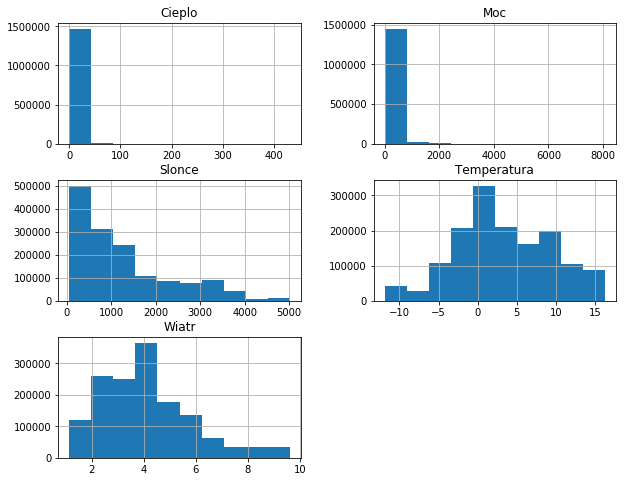

In [11]:
# histogram dla wartości numerycznych (widać, ze niewielka liczba wezłów charakterzyuje sie bardzo dużą mocą i 
# dużym zużyciem - na razie nie usuwam ich jako wartości odstających
all_data.hist();

In [12]:
all_data.describe()

,Cieplo,Temperatura,Wiatr,Slonce,Moc
count,1.478630e+06,1.478630e+06,1.478630e+06,1.478630e+06,1.478630e+06
mean,3.685656e+00,3.274777e+00,4.128263e+00,1.248129e+03,1.275046e+02
std,8.079952e+00,6.168158e+00,1.730237e+00,1.079314e+03,2.578502e+02
min,1.000000e-02,-1.189167e+01,1.137500e+00,5.250000e+01,1.000000e+00
25%,3.300000e-01,-7.583333e-01,2.797917e+00,4.255000e+02,9.000000e+00
50%,1.540000e+00,2.541667e+00,3.975000e+00,8.745000e+02,7.000000e+01
75%,4.340000e+00,8.033333e+00,4.995833e+00,1.700500e+03,1.460000e+02
max,4.310000e+02,1.631458e+01,9.606250e+00,5.016000e+03,8.080000e+03


In [13]:
all_data.corr()

,Cieplo,Temperatura,Wiatr,Slonce,Moc
Cieplo,1.000000,-0.148181,0.005956,-0.053939,0.812312
Temperatura,-0.148181,1.000000,0.024533,0.297275,0.010276
Wiatr,0.005956,0.024533,1.000000,0.008209,-0.000741
Slonce,-0.053939,0.297275,0.008209,1.000000,0.003812
Moc,0.812312,0.010276,-0.000741,0.003812,1.000000


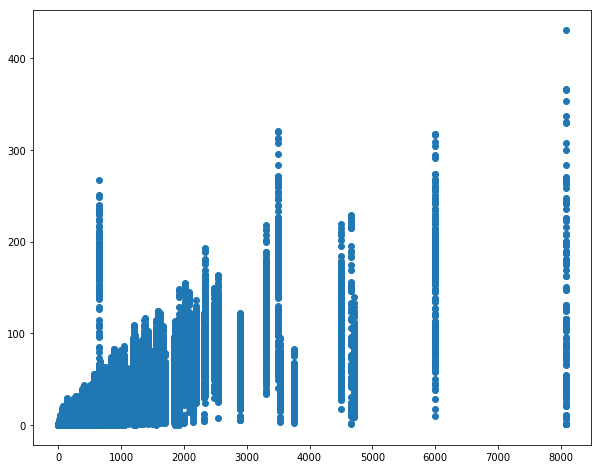

In [14]:
# wykres zuzycia ciepła od mocy zamówionej  - widać w zakresie poniżej 1000 kW grupę znacznie odbiegających od
# standardu zuzyć 
y = all_data['Cieplo']
x = all_data['Moc']
plt.scatter(x,y)
plt.show()

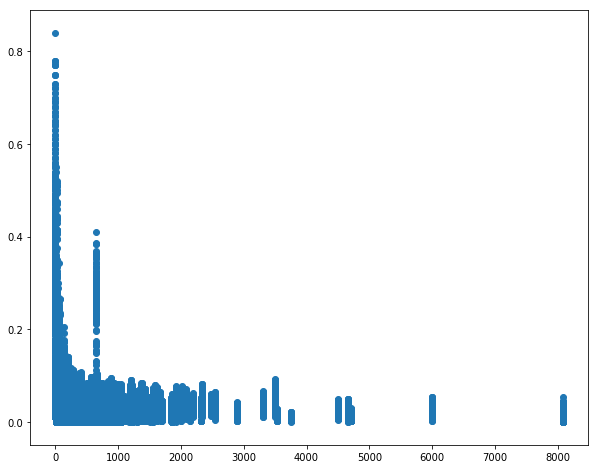

In [15]:
# postaram się usunąć odczyty które wykazują bardzo duży pobór ciepła względem zamówionej mocy
# w tym celu dodam pomocniczą kolumnę - iloraz zuzycia ciepła i mocy zamówionej
all_data['cieplo/moc'] = all_data['Cieplo']/all_data['Moc']

plt.scatter(all_data['Moc'], all_data['cieplo/moc'])
plt.show()

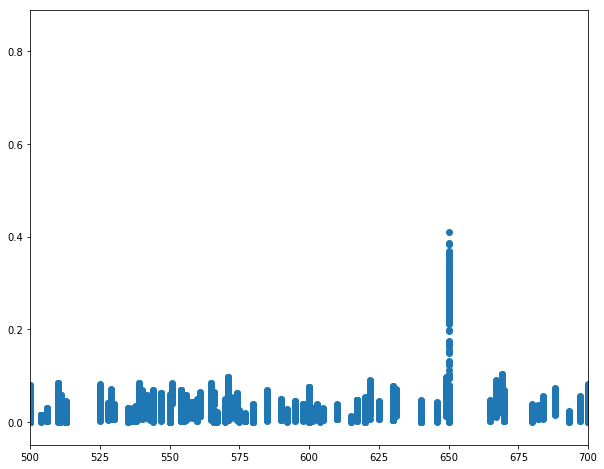

In [16]:
# widać, bardzo duży rozrzut poboru ciepła względem mocy dla najmniejszych mocy (wynika to z błędnie dobranych mocy 
# przez najmniejszych odbiorców) - te zużycia na razie zostawiam, dla mocy wyzszych pobór się normuje
# zmniejszam zakres osi x aby zobaczyc dla jakich wartości mocy są odstające wartości wspólczynnika
plt.scatter(all_data['Moc'], all_data['cieplo/moc'] )
plt.xlim(500,700)
plt.show()

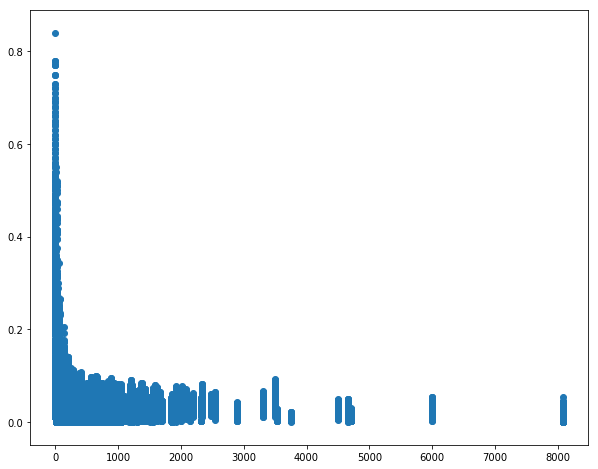

In [17]:
# usuwam wiersze gdzie wartośc wspóczynnika jest większa, niż 0.1 i moc jest większa od 600 kW

def odstajace_zuzycia(row):
    if (row['cieplo/moc'] > 0.1) and row['Moc'] > 600:
        return "tak"
    else:
        return "nie"

all_data['czy_usunac'] = all_data.apply(odstajace_zuzycia, axis=1)   

wskaznik = all_data[all_data['czy_usunac'] == 'tak' ].index
all_data.drop(wskaznik , inplace=True)

plt.scatter(all_data['Moc'], all_data['cieplo/moc'] )
plt.show()

In [19]:
# podejrzewam, że najwyższe współczynniki osiągają odbiorcy z grupy "domki jednorodzinne". Sprawdźmy czy to prawda
pivot_table = pd.pivot_table(all_data,index=['Odbiorca'],values=["cieplo/moc"],aggfunc=[np.mean,min,max])

pivot_table

,mean,min,max
,cieplo/moc,cieplo/moc,cieplo/moc
Odbiorca,,,
Domki jednorodzinne,0.036183,0.000222,0.840000
Handel i usługi,0.026893,0.000058,0.520000
Instytucje,0.028587,0.000048,0.550000
Mieszkania,0.031756,0.000714,0.216667
Przemysł,0.029471,0.000200,0.158000
Spółdzielnie Mieszkaniowe,0.035932,0.000069,0.343962
Służba Zdrowia,0.027144,0.000182,0.134286
Wspólnoty Mieszkaniowe,0.030759,0.000068,0.210625


In [20]:
# faktycznie! na razie, nic z tym nie zrobię, ale później sprawdzimy wyniki regresji dla zbioru bez tej gr. odbiorców
# usuwam kolumny pomocnicze
all_data.drop(all_data.columns[[9,10]],axis=1,inplace=True) 
all_data.head()

,Cieplo,Czy_weekend,Temperatura,Wiatr,Slonce,Funkcja,Typ,Moc,Odbiorca
0,6.6,nie,7.010417,5.189583,498.0,Dwufunkcyjny,INDYWIDUALNY,204,Instytucje
1,8.9,nie,1.745833,2.172917,610.5,Dwufunkcyjny,INDYWIDUALNY,204,Instytucje
2,8.8,nie,2.364583,6.089583,424.0,Dwufunkcyjny,INDYWIDUALNY,204,Instytucje
3,8.5,nie,3.977083,5.687500,432.5,Dwufunkcyjny,INDYWIDUALNY,204,Instytucje
4,8.0,nie,5.006250,6.012500,336.5,Dwufunkcyjny,INDYWIDUALNY,204,Instytucje


In [21]:
all_data.describe()

,Cieplo,Temperatura,Wiatr,Slonce,Moc
count,1.478523e+06,1.478523e+06,1.478523e+06,1.478523e+06,1.478523e+06
mean,3.673399e+00,3.275006e+00,4.128264e+00,1.248113e+03,1.274668e+02
std,7.942063e+00,6.168129e+00,1.730236e+00,1.079317e+03,2.578212e+02
min,1.000000e-02,-1.189167e+01,1.137500e+00,5.250000e+01,1.000000e+00
25%,3.300000e-01,-7.583333e-01,2.797917e+00,4.255000e+02,9.000000e+00
50%,1.540000e+00,2.541667e+00,3.975000e+00,8.745000e+02,7.000000e+01
75%,4.330000e+00,8.033333e+00,4.995833e+00,1.700500e+03,1.460000e+02
max,4.310000e+02,1.631458e+01,9.606250e+00,5.016000e+03,8.080000e+03


In [22]:
# na poczatek modelowania zbuduję model regresji liniowej z wykorzystaniem tylko zmiennych liczbowych

def Regresja_Liniowa(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    r = sklearn.linear_model.LinearRegression()
    r.fit(x_train, y_train)
    y_train_pred = r.predict(x_train)
    y_test_pred = r.predict(x_test)
 
    print ("MAE_train=", sklearn.metrics.mean_absolute_error(y_train, y_train_pred))
    print ("MAE_test=", sklearn.metrics.mean_absolute_error(y_test, y_test_pred)) 
    print ("MSE_train=", sklearn.metrics.mean_squared_error(y_train, y_train_pred))
    print ("MSE_test=", sklearn.metrics.mean_squared_error(y_test, y_test_pred)) 
    print("r_score_train=", sklearn.metrics.r2_score(y_train, y_train_pred))
    print("r_score_test=", sklearn.metrics.r2_score(y_test, y_test_pred))
    
x = all_data[['Temperatura', 'Wiatr', 'Slonce', 'Moc']]
y = all_data['Cieplo']

Regresja_Liniowa(x, y, 0.2)

MAE_train= 1.7130429594183632
MAE_test= 1.7316923993719406
MSE_train= 18.252519228110582
MSE_test= 20.55845939913733
r_score_train= 0.7091709227137759
r_score_test= 0.6804734515059139


In [23]:
# raczej słabo, zobaczmy jak zmiana rozmiaru zbioru treningowego wpływa na wartości przewidywane
print("Zbiór testowy 0.3")
Regresja_Liniowa(x, y, 0.3)
print()
print('Zbiór testowy 0.1')
Regresja_Liniowa(x, y, 0.1)

Zbiór testowy 0.3
MAE_train= 1.7119551501592458
MAE_test= 1.7268091316617098
MSE_train= 18.2727637336727
MSE_test= 19.74073557817012
r_score_train= 0.7077183395603563
r_score_test= 0.6933704474186035

Zbiór testowy 0.1
MAE_train= 1.7156908720674526
MAE_test= 1.7354376260762459
MSE_train= 18.452076218900103
MSE_test= 21.060638896281496
r_score_train= 0.705862933331369
r_score_test= 0.6817037652925346


In [24]:
#teraz zmnienie wartości kategoryczne na zero jedynkowe i wyskaluje wartosci liczbowe
all_data[['Temperatura', 'Wiatr', 'Slonce', 'Moc']] = StandardScaler().fit_transform(all_data[['Temperatura', 'Wiatr', 'Slonce', 'Moc']])

all_data = pd.concat([all_data,pd.get_dummies(all_data['Czy_weekend'], prefix='Weekend')],axis=1)
all_data = pd.concat([all_data,pd.get_dummies(all_data['Funkcja'], prefix='Funkcja')],axis=1)
all_data = pd.concat([all_data,pd.get_dummies(all_data['Typ'], prefix='Typ')],axis=1)
all_data = pd.concat([all_data,pd.get_dummies(all_data['Odbiorca'], prefix='Odbiorca')],axis=1)

all_data.drop(all_data.columns[[1,5,6,8]],axis=1,inplace=True) 
all_data.head()

,Cieplo,Temperatura,Wiatr,Slonce,Moc,Weekend_nie,Weekend_tak,Funkcja_Czterofunkcyjny,Funkcja_Dwufunkcyjny,Funkcja_Jednofunkcyjny,Funkcja_Trzyfunkcyjny,Typ_GRUPOWY,Typ_INDYWIDUALNY,Odbiorca_Domki jednorodzinne,Odbiorca_Handel i usługi,Odbiorca_Instytucje,Odbiorca_Mieszkania,Odbiorca_Przemysł,Odbiorca_Spółdzielnie Mieszkaniowe,Odbiorca_Służba Zdrowia,Odbiorca_Wspólnoty Mieszkaniowe,Odbiorca_inne
0,6.6,0.605599,0.613396,-0.694988,0.296846,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
1,8.9,-0.247915,-1.130105,-0.590756,0.296846,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
2,8.8,-0.147601,1.133557,-0.763550,0.296846,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
3,8.5,0.113823,0.901170,-0.755675,0.296846,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,8.0,0.280676,1.089006,-0.844620,0.296846,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0


In [25]:
# teraz wyuczę model regresji liniowej na podstawie przetworzonych danych
dane = all_data.drop('Cieplo', axis = 1)
cieplo = pd.DataFrame(all_data['Cieplo'])

print("Zbiór testowy 0.3")
Regresja_Liniowa(dane, cieplo, 0.3)
print()
print('Zbiór testowy 0.2')
Regresja_Liniowa(dane, cieplo, 0.2)
print()
print('Zbiór testowy 0.1')
Regresja_Liniowa(dane, cieplo, 0.1)

Zbiór testowy 0.3
MAE_train= 1.6514594372846545
MAE_test= 1.6622339406209352
MSE_train= 16.57345216002279
MSE_test= 17.94117845588136
r_score_train= 0.7348996469744851
r_score_test= 0.7213226679965572

Zbiór testowy 0.2
MAE_train= 1.6518655765547157
MAE_test= 1.6674124432236097
MSE_train= 16.55641032841178
MSE_test= 18.694473776471092
r_score_train= 0.7361961119554157
r_score_test= 0.7094441482341977

Zbiór testowy 0.1
MAE_train= 1.6541799091634768
MAE_test= 1.671643591681856
MSE_train= 16.74172227564705
MSE_test= 19.153262259513657
r_score_train= 0.7331269921757761
r_score_test= 0.7105305641680133


In [26]:
# jest mały progres. Przerobię funkcję z regresją liniową o warstwowy podział zbioru na testowy i treningowy
# dokonam podziału wg typu węzła (czy zasila jednego, czy więcej niz jednego odbiorcę)

def Regresja_liniowa_stratified(dane, podzial, n_splits, test_size):
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)

    for train_index, test_index in split.split(dane, podzial):
        strat_train_set = dane.loc[train_index]
        strat_test_set = dane.loc[test_index]
        
        
    strat_train_set = strat_train_set.dropna(axis=0)
    strat_test_set = strat_test_set.dropna(axis=0)
    x_train = strat_train_set.drop('Cieplo', axis = 1)
    y_train = pd.DataFrame(strat_train_set['Cieplo'])
    x_test = strat_test_set.drop('Cieplo', axis = 1)
    y_test = pd.DataFrame(strat_test_set['Cieplo'])

    r = sklearn.linear_model.LinearRegression()
    r.fit(x_train, y_train)
    y_train_pred = r.predict(x_train)
    y_test_pred = r.predict(x_test)
 
    print ("MAE_train=", sklearn.metrics.mean_absolute_error(y_train, y_train_pred))
    print ("MAE_test=", sklearn.metrics.mean_absolute_error(y_test, y_test_pred)) 
    print ("MSE_train=", sklearn.metrics.mean_squared_error(y_train, y_train_pred))
    print ("MSE_test=", sklearn.metrics.mean_squared_error(y_test, y_test_pred)) 
    print("r_score_train=", sklearn.metrics.r2_score(y_train, y_train_pred))
    print("r_score_test=", sklearn.metrics.r2_score(y_test, y_test_pred))

In [27]:
print("Zbiór testowy 0.3")
Regresja_liniowa_stratified(all_data, all_data["Typ_INDYWIDUALNY"], 1, 0.3)
print()
print("Zbiór testowy 0.2")
Regresja_liniowa_stratified(all_data, all_data["Typ_INDYWIDUALNY"], 1, 0.2)
print()
print('Zbiór testowy 0.1')
Regresja_liniowa_stratified(all_data, all_data["Typ_INDYWIDUALNY"], 1, 0.1)

Zbiór testowy 0.3
MAE_train= 1.6285763656920724
MAE_test= 1.6289918763371452
MSE_train= 14.988415400347082
MSE_test= 15.056607692654367
r_score_train= 0.7533016032879203
r_score_test= 0.7493209301447461

Zbiór testowy 0.2
MAE_train= 1.6283730456597412
MAE_test= 1.6304431486930517
MSE_train= 14.932057974925138
MSE_test= 15.316641494360479
r_score_train= 0.7538130692102901
r_score_test= 0.7452636832253845

Zbiór testowy 0.1
MAE_train= 1.6275269250058455
MAE_test= 1.6290640042474391
MSE_train= 14.921866664752777
MSE_test= 15.786064273688911
r_score_train= 0.752713319335167
r_score_test= 0.7470190921290234


In [28]:
# no ok, najlepsze wyniki otrzymujemy dla wartwowego podziału i zbioru testowego 0.3
# spróbujmy teraz wyuczyć bardziej zaawansowany model

def LosowyLas(regr,dane, podzial, n_splits, test_size):
    
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)

    for train_index, test_index in split.split(dane, podzial):
        strat_train_set = dane.loc[train_index]
        strat_test_set = dane.loc[test_index]

    strat_train_set = strat_train_set.dropna(axis=0)
    strat_test_set = strat_test_set.dropna(axis=0)
    x_train = strat_train_set.drop('Cieplo', axis = 1)
    y_train = pd.DataFrame(strat_train_set['Cieplo'])
    x_test = strat_test_set.drop('Cieplo', axis = 1)
    y_test = pd.DataFrame(strat_test_set['Cieplo'])
    
    regr = regr
    regr.fit(x_train, y_train.values.ravel())
    y_train_pred = regr.predict(x_train)
    y_test_pred = regr.predict(x_test)
    MAE_train= sklearn.metrics.mean_absolute_error(y_train, y_train_pred)
    MAE_test= sklearn.metrics.mean_absolute_error(y_test, y_test_pred) 
    MSE_train= sklearn.metrics.mean_squared_error(y_train, y_train_pred)
    MSE_test=sklearn.metrics.mean_squared_error(y_test, y_test_pred)
    r_score_train= sklearn.metrics.r2_score(y_train, y_train_pred)
    r_score_test=sklearn.metrics.r2_score(y_test, y_test_pred)
    print('MAE_train= ',MAE_train)
    print('MAE_test= ',MAE_test)
    print('MSE_train= ',MSE_train)
    print('MSE_test= ',MSE_test)
    print('r_score_train= ',r_score_train)
    print('r_score_test= ',r_score_test)

In [29]:
regr = RandomForestRegressor()

print("Zbiór testowy 0.3")
LosowyLas(regr, all_data, all_data["Typ_INDYWIDUALNY"], 1, 0.3)
print()
print("Zbiór testowy 0.2")
LosowyLas(regr, all_data, all_data["Typ_INDYWIDUALNY"], 1, 0.2)
print()
print("Zbiór testowy 0.1")
LosowyLas(regr, all_data, all_data["Typ_INDYWIDUALNY"], 1, 0.1)

Zbiór testowy 0.3
MAE_train=  0.43747734357510465
MAE_test=  0.6686013201481136
MSE_train=  0.872645633905928
MSE_test=  2.400664620447611
r_score_train=  0.9855404962527234
r_score_test=  0.9606502575179752

Zbiór testowy 0.2
MAE_train=  0.44617569816584085
MAE_test=  0.6641014562919887
MSE_train=  0.8996875765467405
MSE_test=  2.4331870254176784
r_score_train=  0.985065024912068
r_score_test=  0.9606149988716199

Zbiór testowy 0.1
MAE_train=  0.45320331977936107
MAE_test=  0.6716131228919624
MSE_train=  0.9336894186568407
MSE_test=  2.49296697934164
r_score_train=  0.9845313588925957
r_score_test=  0.9599458972607384


In [30]:
# zobaczmy jakie parametry zostały uzyte przy budowie modelu

print('Parametry użyte w modelu:\n')
pprint(regr.get_params())

Parametry użyte w modelu:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [36]:
#spróbujmy losowo przeszukać siatkę w celu otrzymania optymalnych parametrów

#liczba drzew w lesie
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 7)]
# liczba cech do rozważenia przy każdym podziale
max_features = ['auto', 'sqrt']
# maksymalna liczba poziomów w każdym drzewie
max_depth = [int(x) for x in np.linspace(5, 15, num = 3)]
max_depth.append(None)
# Minimalna liczba cech przy każdym podziale
min_samples_leaf = [1, 2]
# Metoda wyboru przykładów do trenowania każdego drzewa
bootstrap = [True, False]

# Utworzenie siatki do losowego przeszukania
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [10, 25, 40, 55, 70, 85, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, None], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [37]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in split.split(all_data, all_data["Typ_INDYWIDUALNY"]):
    strat_train_set = all_data.loc[train_index]
    strat_test_set = all_data.loc[test_index]

strat_train_set = strat_train_set.dropna(axis=0)
strat_test_set = strat_test_set.dropna(axis=0)
x_train = strat_train_set.drop('Cieplo', axis = 1)
y_train = pd.DataFrame(strat_train_set['Cieplo'])
x_test = strat_test_set.drop('Cieplo', axis = 1)
y_test = pd.DataFrame(strat_test_set['Cieplo'])

In [38]:
# Przeszukaj losowo siatkę parametrów przy uzyciu 3-krotnej walidacji krzyzowej i przeszukaj 20 kombinacji parametrów
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train.values.ravel())

rf_random.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 56.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 118.5min finished


{'n_estimators': 100,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [39]:
# ok, mamy wyniki :)
# teraz porównam wyniki predykcji lasów z domyslnymi i optymalnymi parametrami dla zbioru treningowego

rf = RandomForestRegressor()
wyniki = cross_val_score(rf, x_train, y_train, cv=10, scoring = "r2")
print("Dokładność_domyslne:", wyniki)
print("Średnia_domyslne:", wyniki.mean())
print("Odchylenie standardowe_domyslne:", wyniki.std())

rf = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 2)
wyniki = cross_val_score(rf, x_train, y_train, cv=10, scoring = "r2")
print("Dokładność_opt:", wyniki)
print("Średnia_opt:", wyniki.mean())
print("Odchylenie standardowe_opt:", wyniki.std())


Dokładność_domyslne: [0.9610787  0.9550403  0.95872628 0.96066352 0.96332436 0.95923578
 0.96221834 0.9632324  0.96304443 0.95809334]
Średnia_domyslne: 0.9604657449529256
Odchylenie standardowe_domyslne: 0.0025605539706650103
Dokładność_opt: [0.96481627 0.95947999 0.96330126 0.96428592 0.96698657 0.96365251
 0.96625275 0.96738912 0.96735887 0.96327832]
Średnia_opt: 0.9646801582943372
Odchylenie standardowe_opt: 0.002333340198021712


In [40]:
# bez sensu było puszczać cv = 10, no nic
# jeszcze porównajmy wyniki dla zbioru testowego
rf = RandomForestRegressor()
regr.fit(x_train, y_train.values.ravel())
y_test_pred = regr.predict(x_test)
MAE_test= sklearn.metrics.mean_absolute_error(y_test, y_test_pred) 
MSE_test=sklearn.metrics.mean_squared_error(y_test, y_test_pred)
r_score_test=sklearn.metrics.r2_score(y_test, y_test_pred)
print('MAE_test_dom= ',MAE_test)
print('MSE_test_dom= ',MSE_test)
print('r_score_test_dom= ',r_score_test)

rf = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 2)
regr.fit(x_train, y_train.values.ravel())
y_test_pred = regr.predict(x_test)
MAE_test= sklearn.metrics.mean_absolute_error(y_test, y_test_pred) 
MSE_test=sklearn.metrics.mean_squared_error(y_test, y_test_pred)
r_score_test=sklearn.metrics.r2_score(y_test, y_test_pred)
print('MAE_test_opt= ',MAE_test)
print('MSE_test_opt= ',MSE_test)
print('r_score_test_opt= ',r_score_test)

MAE_test_dom=  0.6602655286330406
MSE_test_dom=  2.2772258122304074
r_score_test_dom=  0.9625268646896503
MAE_test_opt=  0.6601677259452341
MSE_test_opt=  2.287965632027268
r_score_test_opt=  0.9623501344250033


In [41]:
# widać, że w sumie parametry losowego lasu nie maja większego znaczenia
# zgodnie z wcześniejszym planem usuwam kategorię odbiorców "domki jednorodzinne" ze zbioru (ze względu na najsłabsze
# dopasowanie mocy zamówionej do realnych potrzeb)
domki = all_data[all_data['Odbiorca_Domki jednorodzinne'] == 1 ].index
all_data.drop(domki , inplace=True)

In [42]:
# porónwajmy jeszcze wyniki losowego lasu dla wartości domyslnych i wybranych wczesniej jako optymalne
regr = RandomForestRegressor()
print("Zbiór testowy 0.2, wartości domyslne")
LosowyLas(regr, all_data, all_data["Typ_INDYWIDUALNY"], 1, 0.2)
print()
regr = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 2)
print("Zbiór testowy 0.2, wartości optymalne")
LosowyLas(regr, all_data, all_data["Typ_INDYWIDUALNY"], 1, 0.2)


Zbiór testowy 0.2, wartości domyslne
MAE_train=  0.47875905133707974
MAE_test=  0.768794523754335
MSE_train=  0.8828245909187237
MSE_test=  2.798650418574024
r_score_train=  0.9907659860077156
r_score_test=  0.9701363310814461

Zbiór testowy 0.2, wartości optymalne
MAE_train=  0.5082024692368631
MAE_test=  0.7233782653510686
MSE_train=  1.0116310557009753
MSE_test=  2.3830951592133234
r_score_train=  0.9894606526578463
r_score_test=  0.9741518779469379


In [43]:
# r2 faktycznie poszedł w górę po usunieciu domków, ale w górę poszły tez MSE i MAE. Wynika to z faktu, że usuneliśmy grupę
# odbiorców charakteryzującą się najmniejszymi zuzyciami (wiec błędy predykcji też były najmniejsze)